# Estimating archaic TMRCAs from the real data

In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(furrr)

devtools::load_all(".")

plan(multiprocess)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/ychr
Loading required package: future
Loading ychr


In [2]:
highcov_gt <- read_vcf(here("data/vcf/full_highcov.vcf.gz"), mindp = 4, maxdp = 0.975)

In [3]:
tafr <- calculate_tafr(highcov_gt)

In [4]:
tmrca_full %<-%
    map_dfr(c("den8", "den4", "mez2", "spy1", "neand", "den"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:10, function(dp) {
                read_genotypes(arch, "full", mindp = dp, tv_only = sites == "tv_only") %>%
                    calculate_tarch(tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [5]:
tmrca_lippold %<-%
    map_dfr(c("den8", "den4", "mez2", "spy1", "elsidron2", "neand", "den"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:10, function(dp) {
                read_genotypes(arch, "lippold", mindp = dp, tv_only = sites == "tv_only") %>%
                    calculate_tarch(tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [6]:
tmrca_exome %<-%
    map_dfr(c("den8", "den4", "mez2", "spy1", "elsidron1", "neand", "den"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:10, function(dp) {
                read_genotypes(arch, "exome", mindp = dp, tv_only = sites == "tv_only") %>%
                    calculate_tarch(tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [ ]:
tmrca_full %<>% mutate(capture = "full")
tmrca_lippold %<>% mutate(capture = "lippold")
tmrca_exome %<>% mutate(capture = "exome")

In [ ]:
tmrca_df <- bind_rows(tmrca_full, tmrca_lippold, tmrca_exome)

In [ ]:
saveRDS(tmrca_df, here("data/rds/tmrca.rds"))

now plot...

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


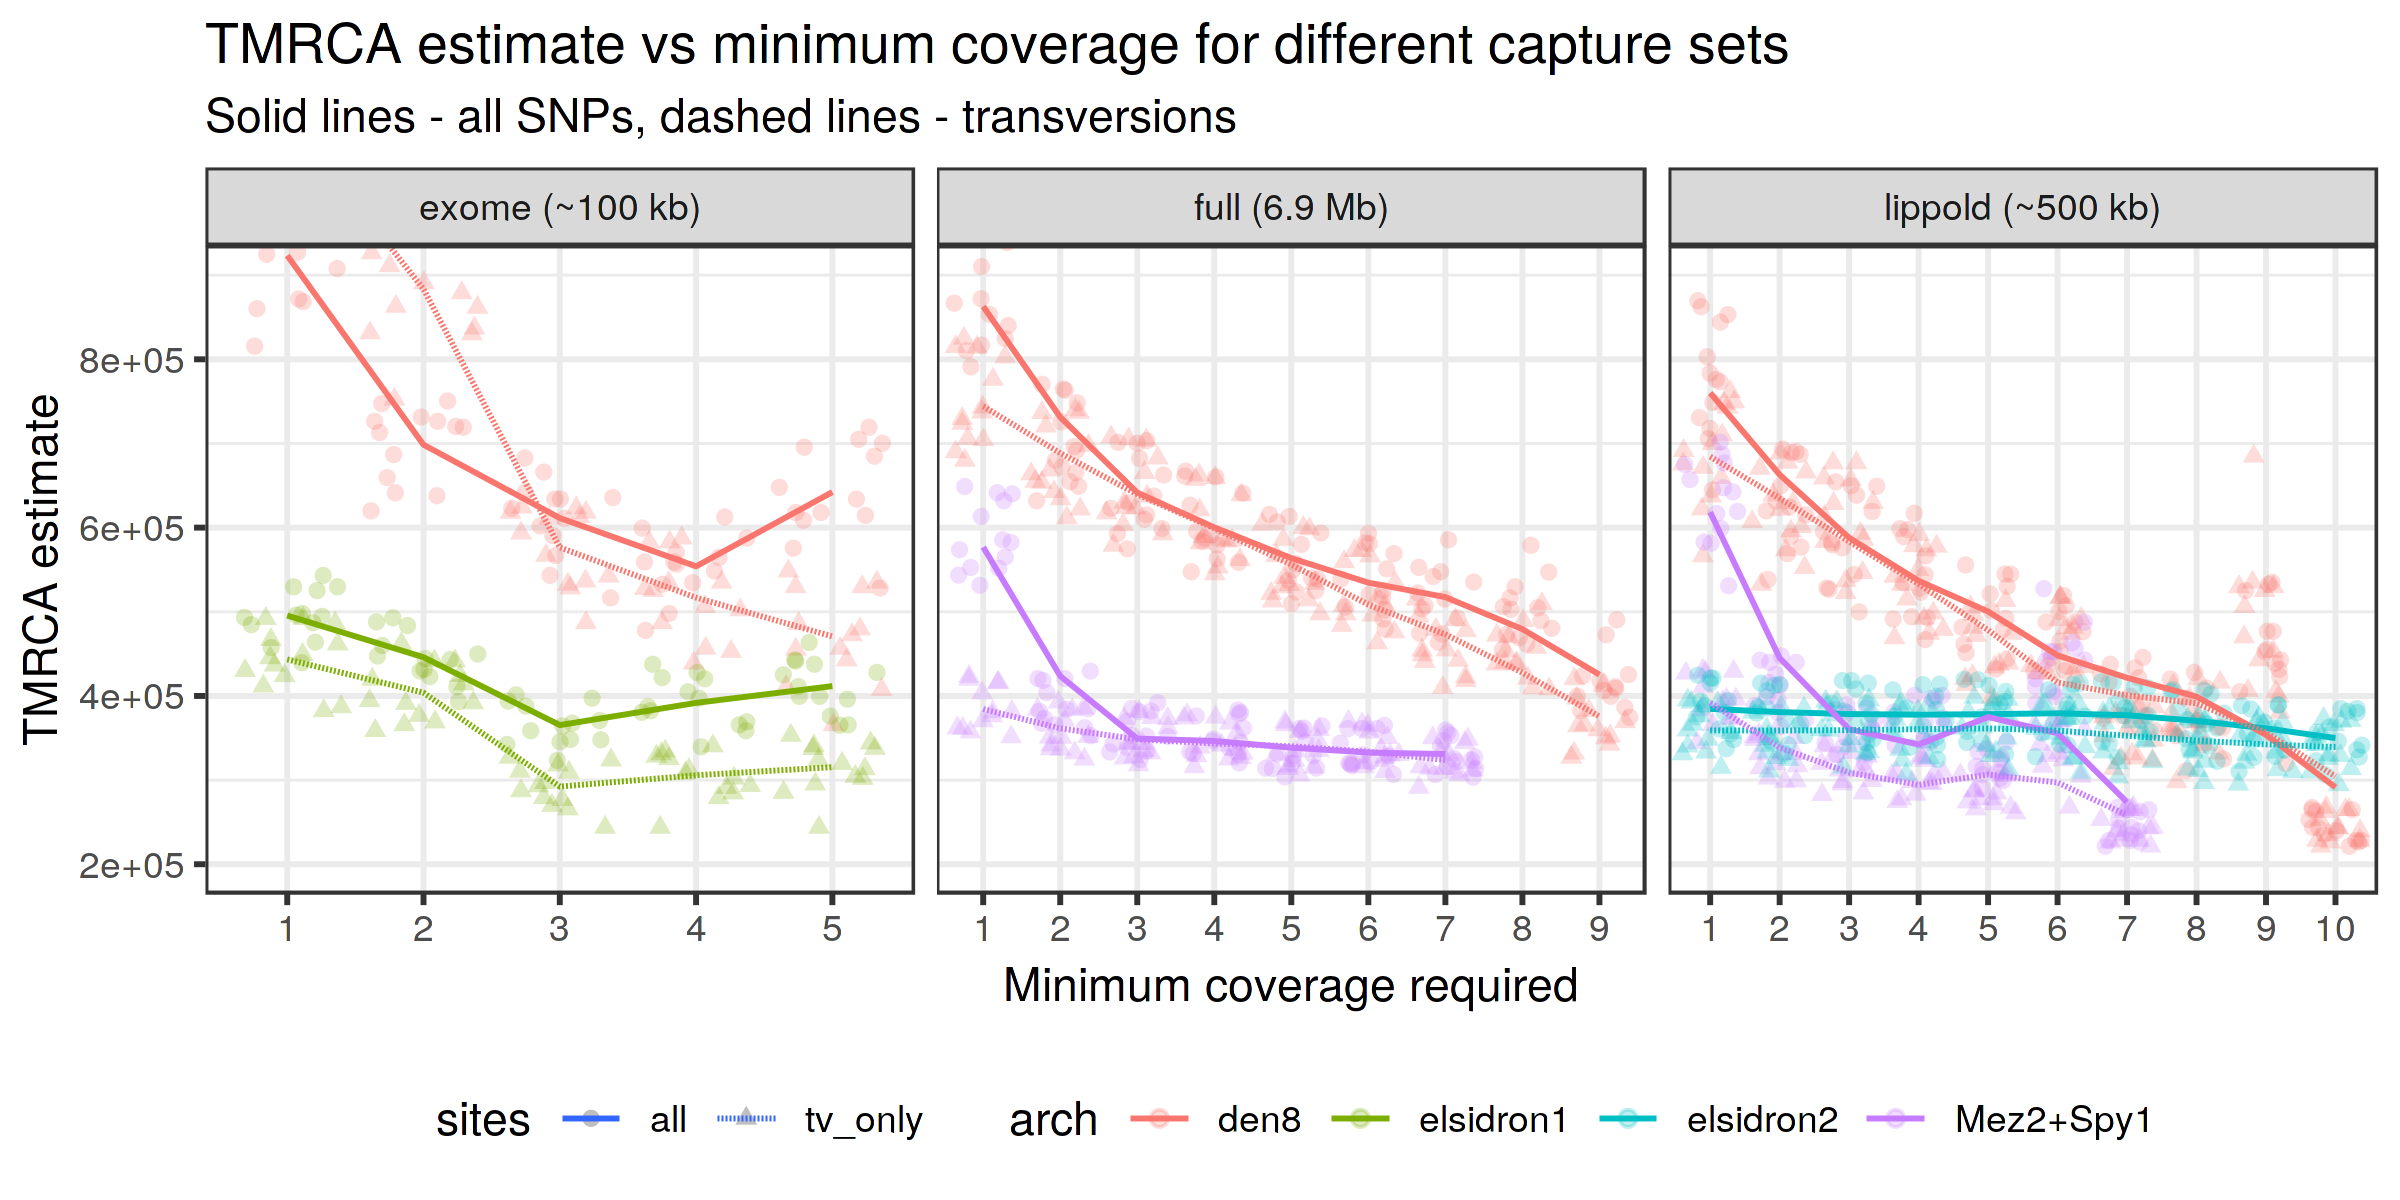

In [64]:
set_dim(8, 4)

tmrca_df %>%
filter(afr == "a00", !is.infinite(alpha), !is.nan(alpha)) %>%
filter(!(arch == "neand" & capture == "exome"), !(capture == "exome" & dp > 5)) %>%
mutate(capture = case_when(capture == "exome" ~ "exome (~100 kb)",
                           capture == "full" ~ "full (6.9 Mb)",
                           capture == "lippold" ~ "lippold (~500 kb)"),
       arch = ifelse(arch == "neand", "Mez2+Spy1", arch)) %>%
unnest(counts_arch) %>%
ggplot(aes(dp, tmrca_arch, color = arch)) +
    geom_jitter(aes(as.factor(dp), tmrca_arch, shape = sites), alpha = 1/4) +
    geom_smooth(aes(linetype = sites), size = 0.5, se = FALSE) +
    labs(x = "Minimum coverage required", y = "TMRCA estimate") +
    theme_bw() +
    facet_wrap(~ capture, scales = "free_x") +
    coord_cartesian(y = c(200000, 900000)) +
    theme(legend.position = "bottom") +
    ggtitle("TMRCA estimate vs minimum coverage for different capture sets",
            "Solid lines - all SNPs, dashed lines - transversions")

points here:

1. 3X coverage seems to remove most of the error effects nicely - best argument for using this cutoff in the middle panel.
2. TV-only removes all erors (TMRCA doesn't change) => sequencing errors minimal beyond aDNA damage.
3. Minimal effect of reference bias with increasing coverage??? Based on the Neanderthal line in the center panel, but significant bias in Denisova?

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


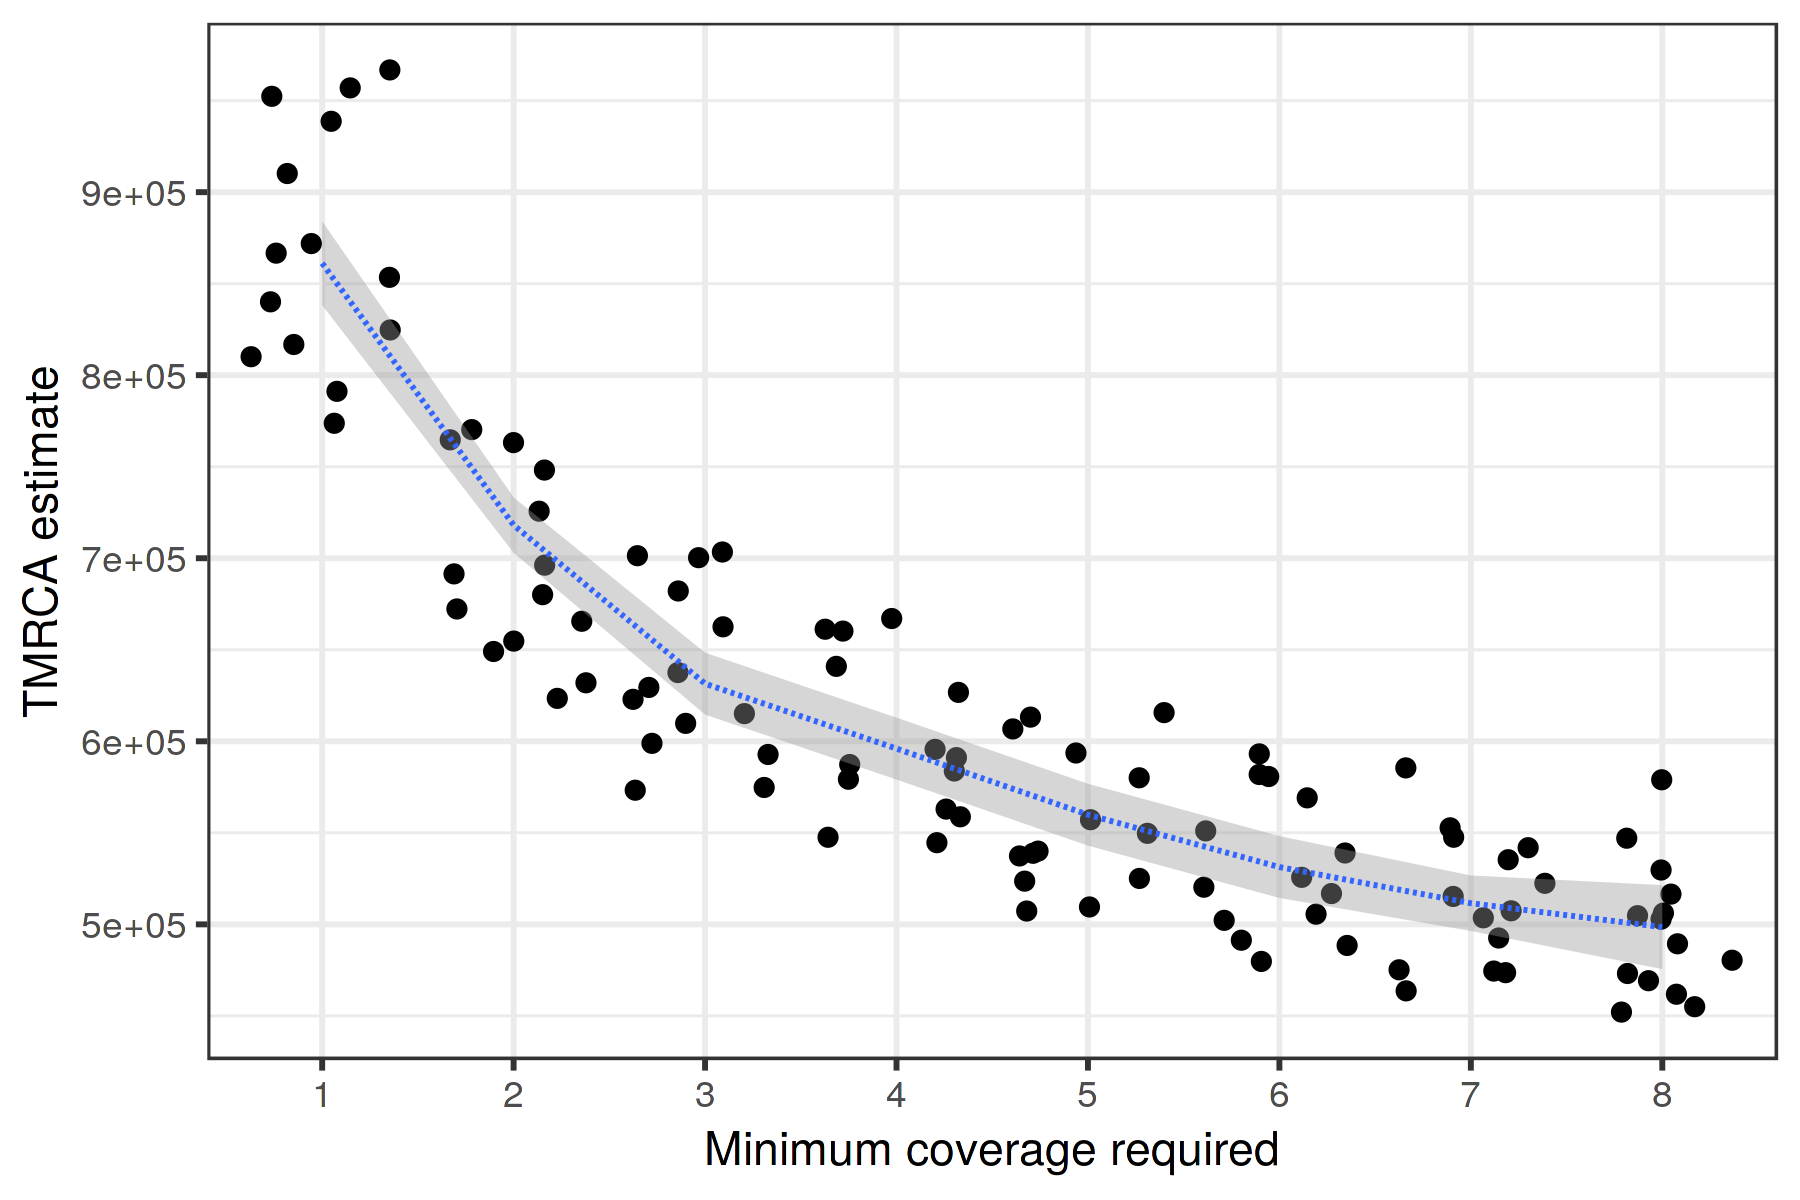

In [20]:
set_dim(6, 4)

tmrca_dp %>%
filter(afr == "a00") %>%
ggplot(aes(dp, tmrca_arch)) +
    geom_jitter(aes(as.factor(dp), tmrca_arch)) +
    geom_smooth(linetype = 2, size = 0.5) +
    labs(x = "Minimum coverage required", y = "TMRCA estimate") +
    theme_bw()

TMRCAs of A00 are overlapping the ones of other Africans, especially striking in the Lippold captures, but exome data looks weird too - too much noise in the data or not enough sequence to accumulate enough informative sites?

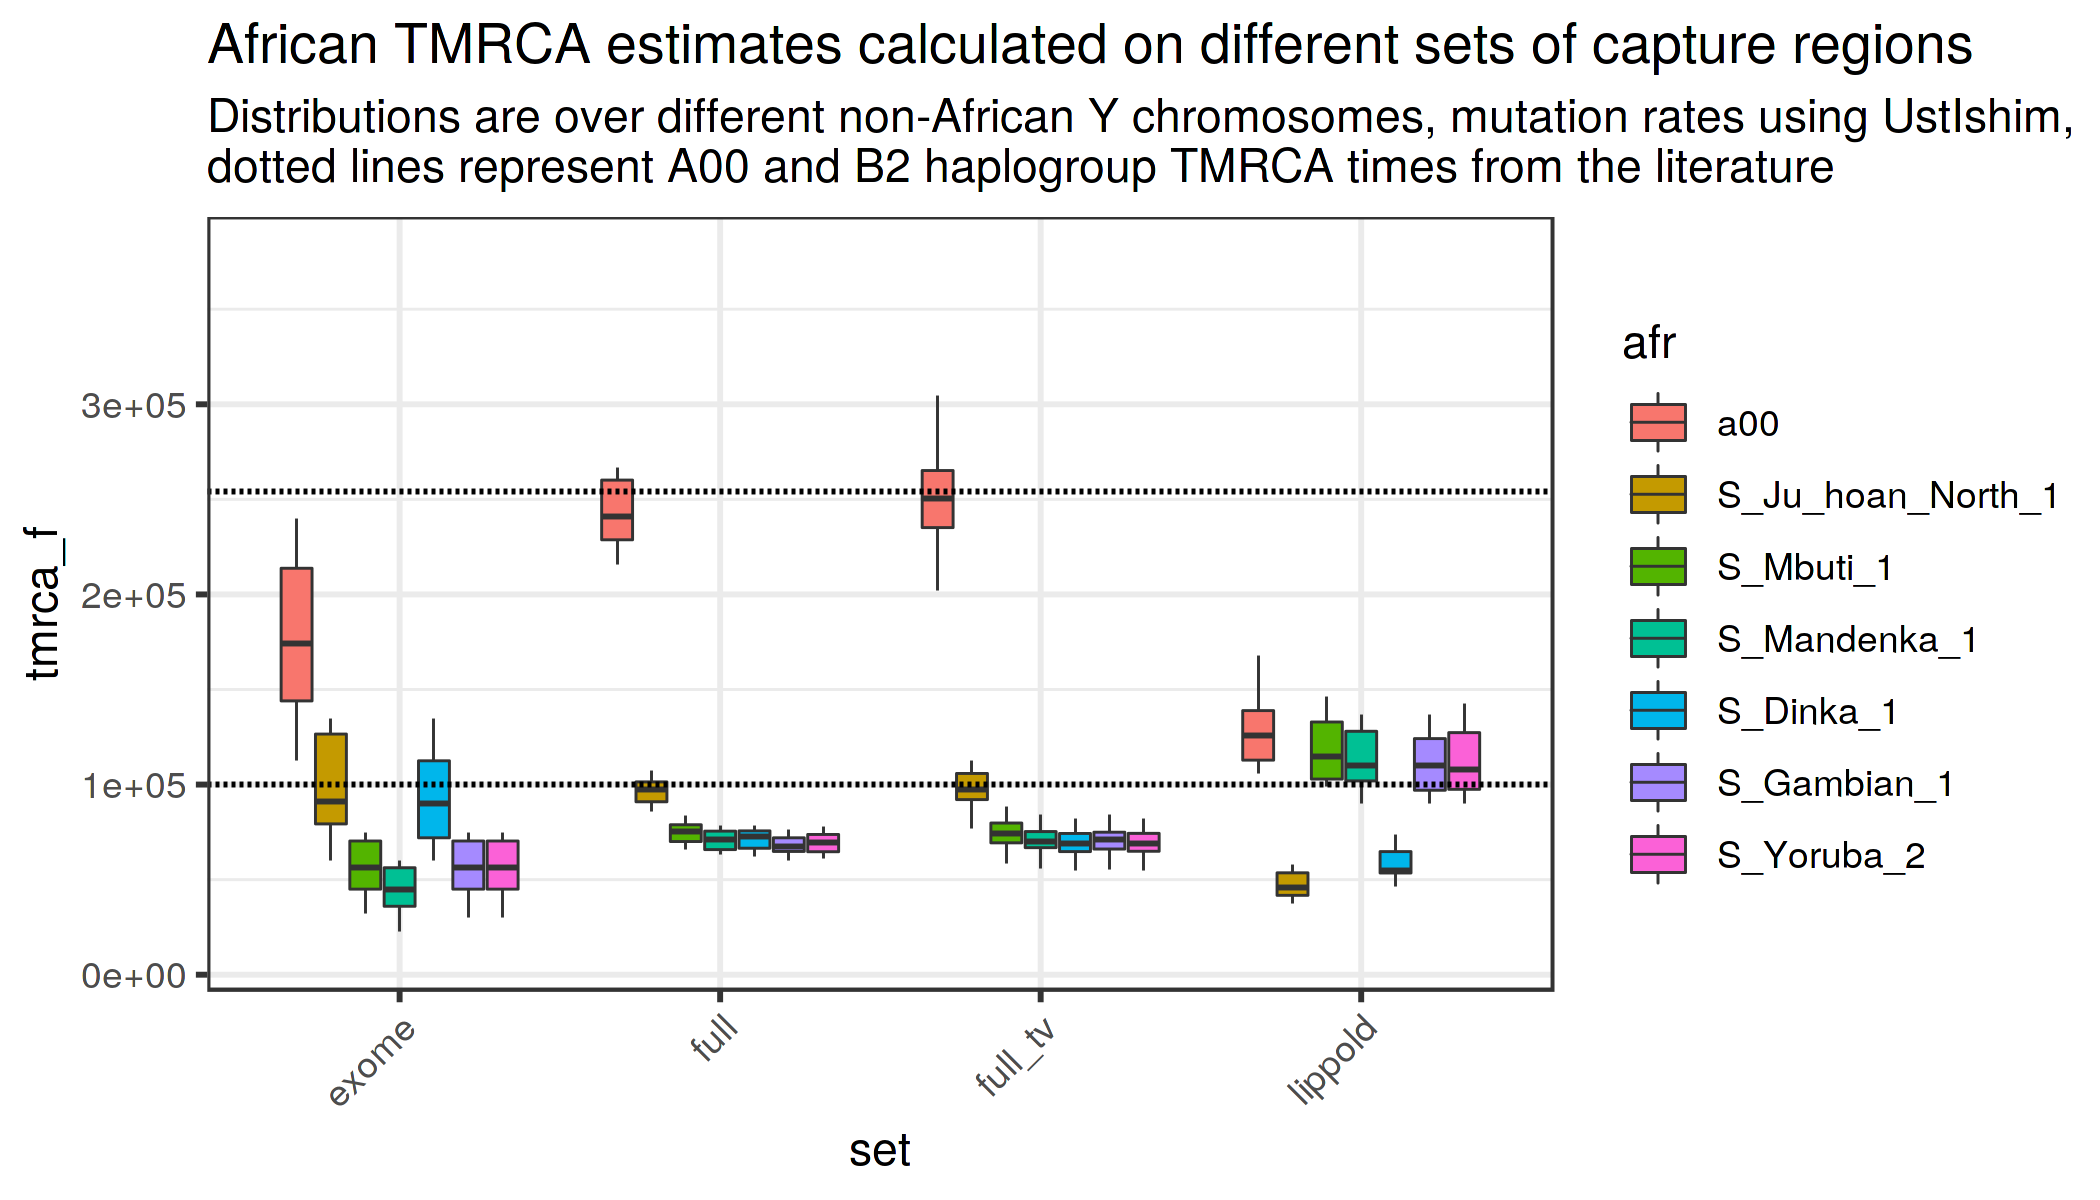

In [28]:
set_dim(7, 4)

tarch %>% filter(arch == "den8", !str_detect(set, "^x")) %>% 
ggplot(aes(set, tmrca_f, fill = fct_reorder(afr, tmrca_afr, .desc = TRUE))) +
    geom_boxplot(outlier.shape = NA, size = 0.25) +
    coord_cartesian(y = c(10000, 380000)) +
    geom_hline(yintercept = c(254000, 100000), linetype = 2, size = 0.5) +
    guides(fill = guide_legend("afr")) +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    ggtitle("African TMRCA estimates calculated on different sets of capture regions",
            "Distributions are over different non-African Y chromosomes, mutation rates using UstIshim,
dotted lines represent A00 and B2 haplogroup TMRCA times from the literature")

$\alpha$ values stable across capture sets for A00, for Denisovans and Neanderthals.

Much lower $\alpha$ values for exome and Lippold regions.

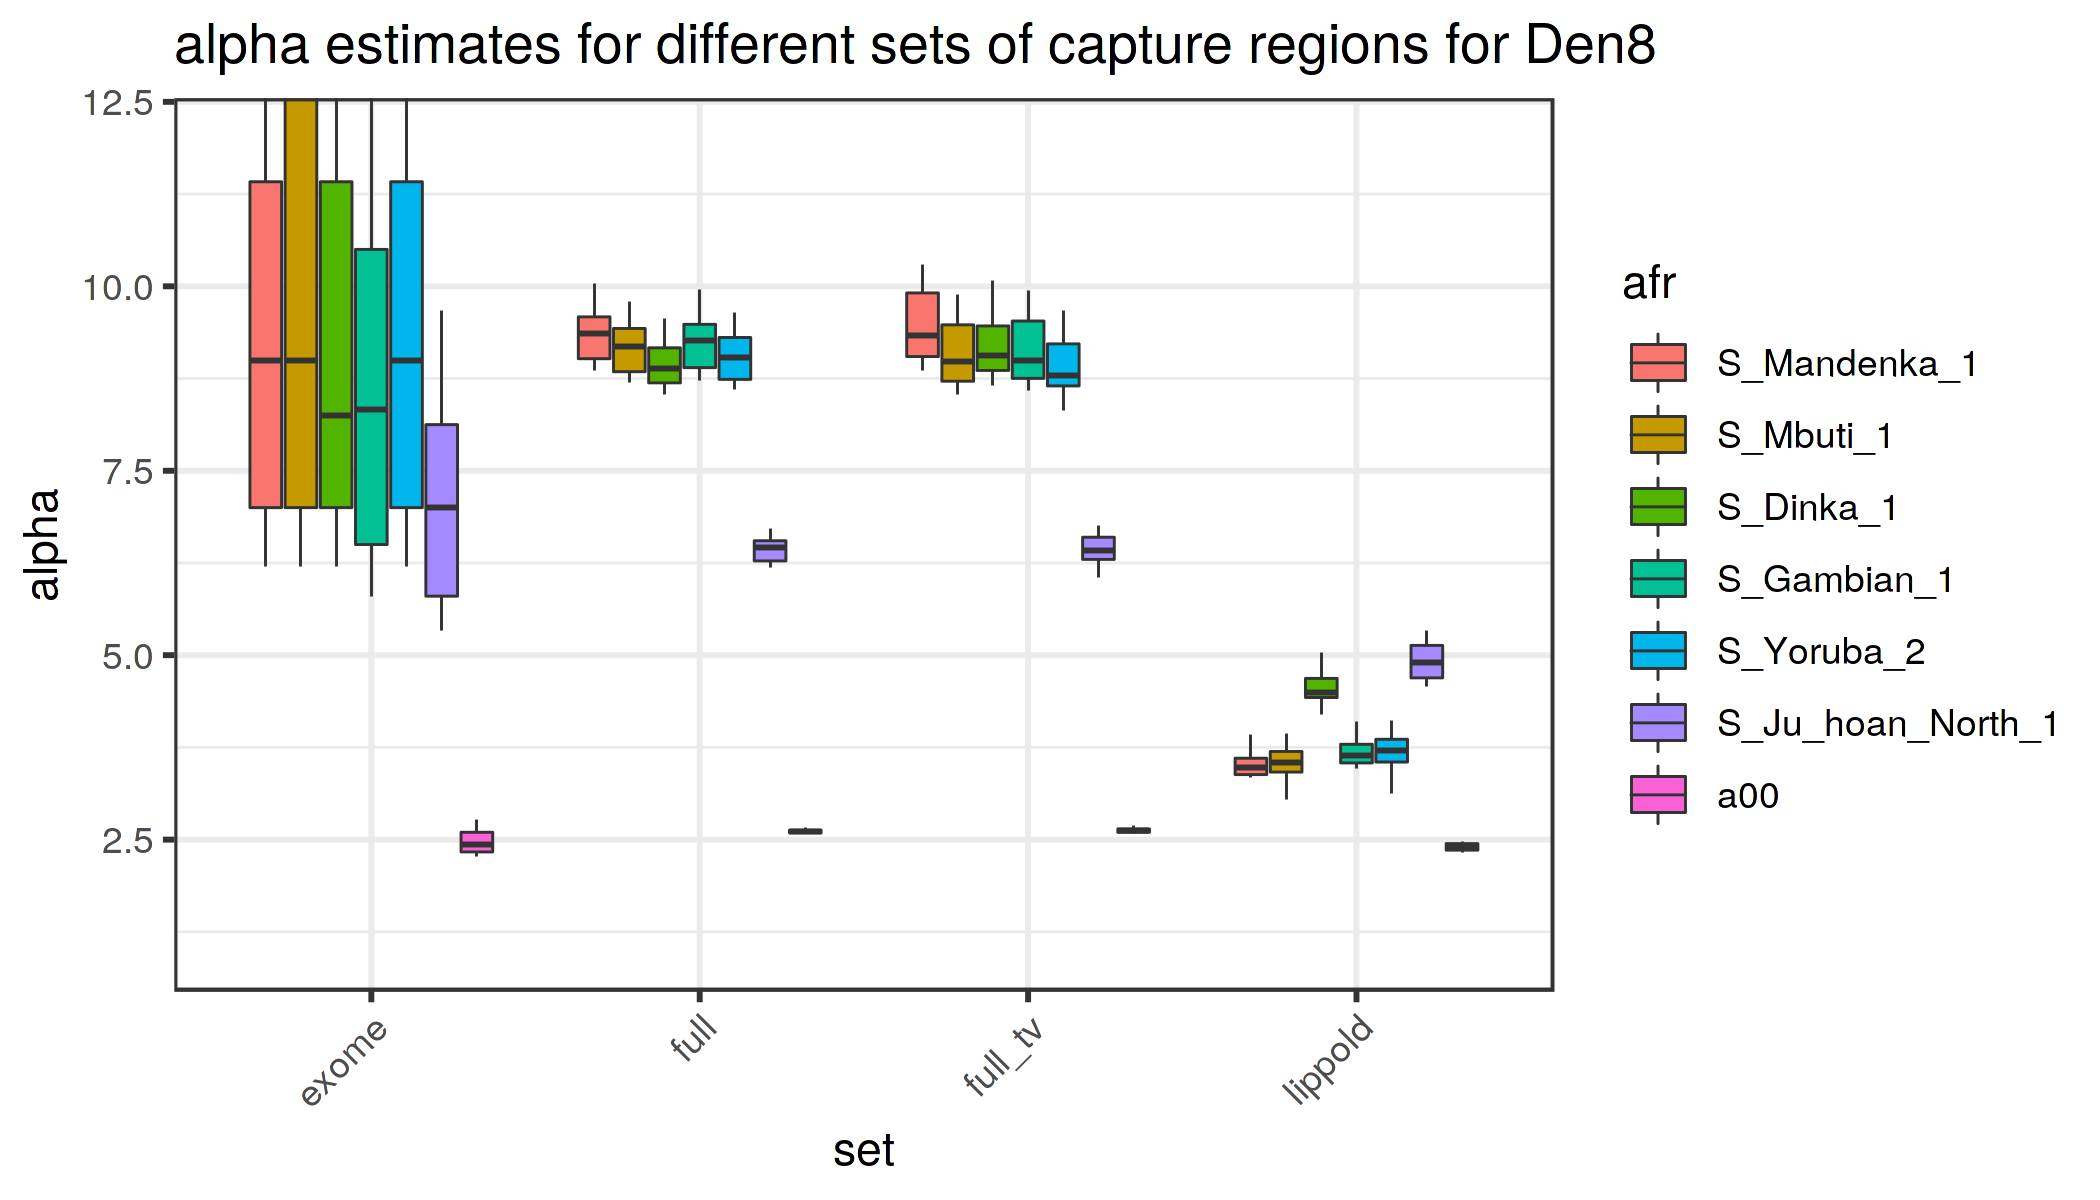

In [30]:
set_dim(7, 4)

tarch %>% filter(arch == "den8", !str_detect(set, "^x")) %>% 
ggplot(aes(set, alpha, fill = fct_reorder(afr, alpha, .desc = TRUE))) +
    geom_boxplot(outlier.shape = NA, size = 0.25) +
    guides(fill = guide_legend("afr")) +
    coord_cartesian(y = c(1, 12)) +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    ggtitle("alpha estimates for different sets of capture regions for Den8")

Warning message:
“Removed 14 rows containing non-finite values (stat_boxplot).”

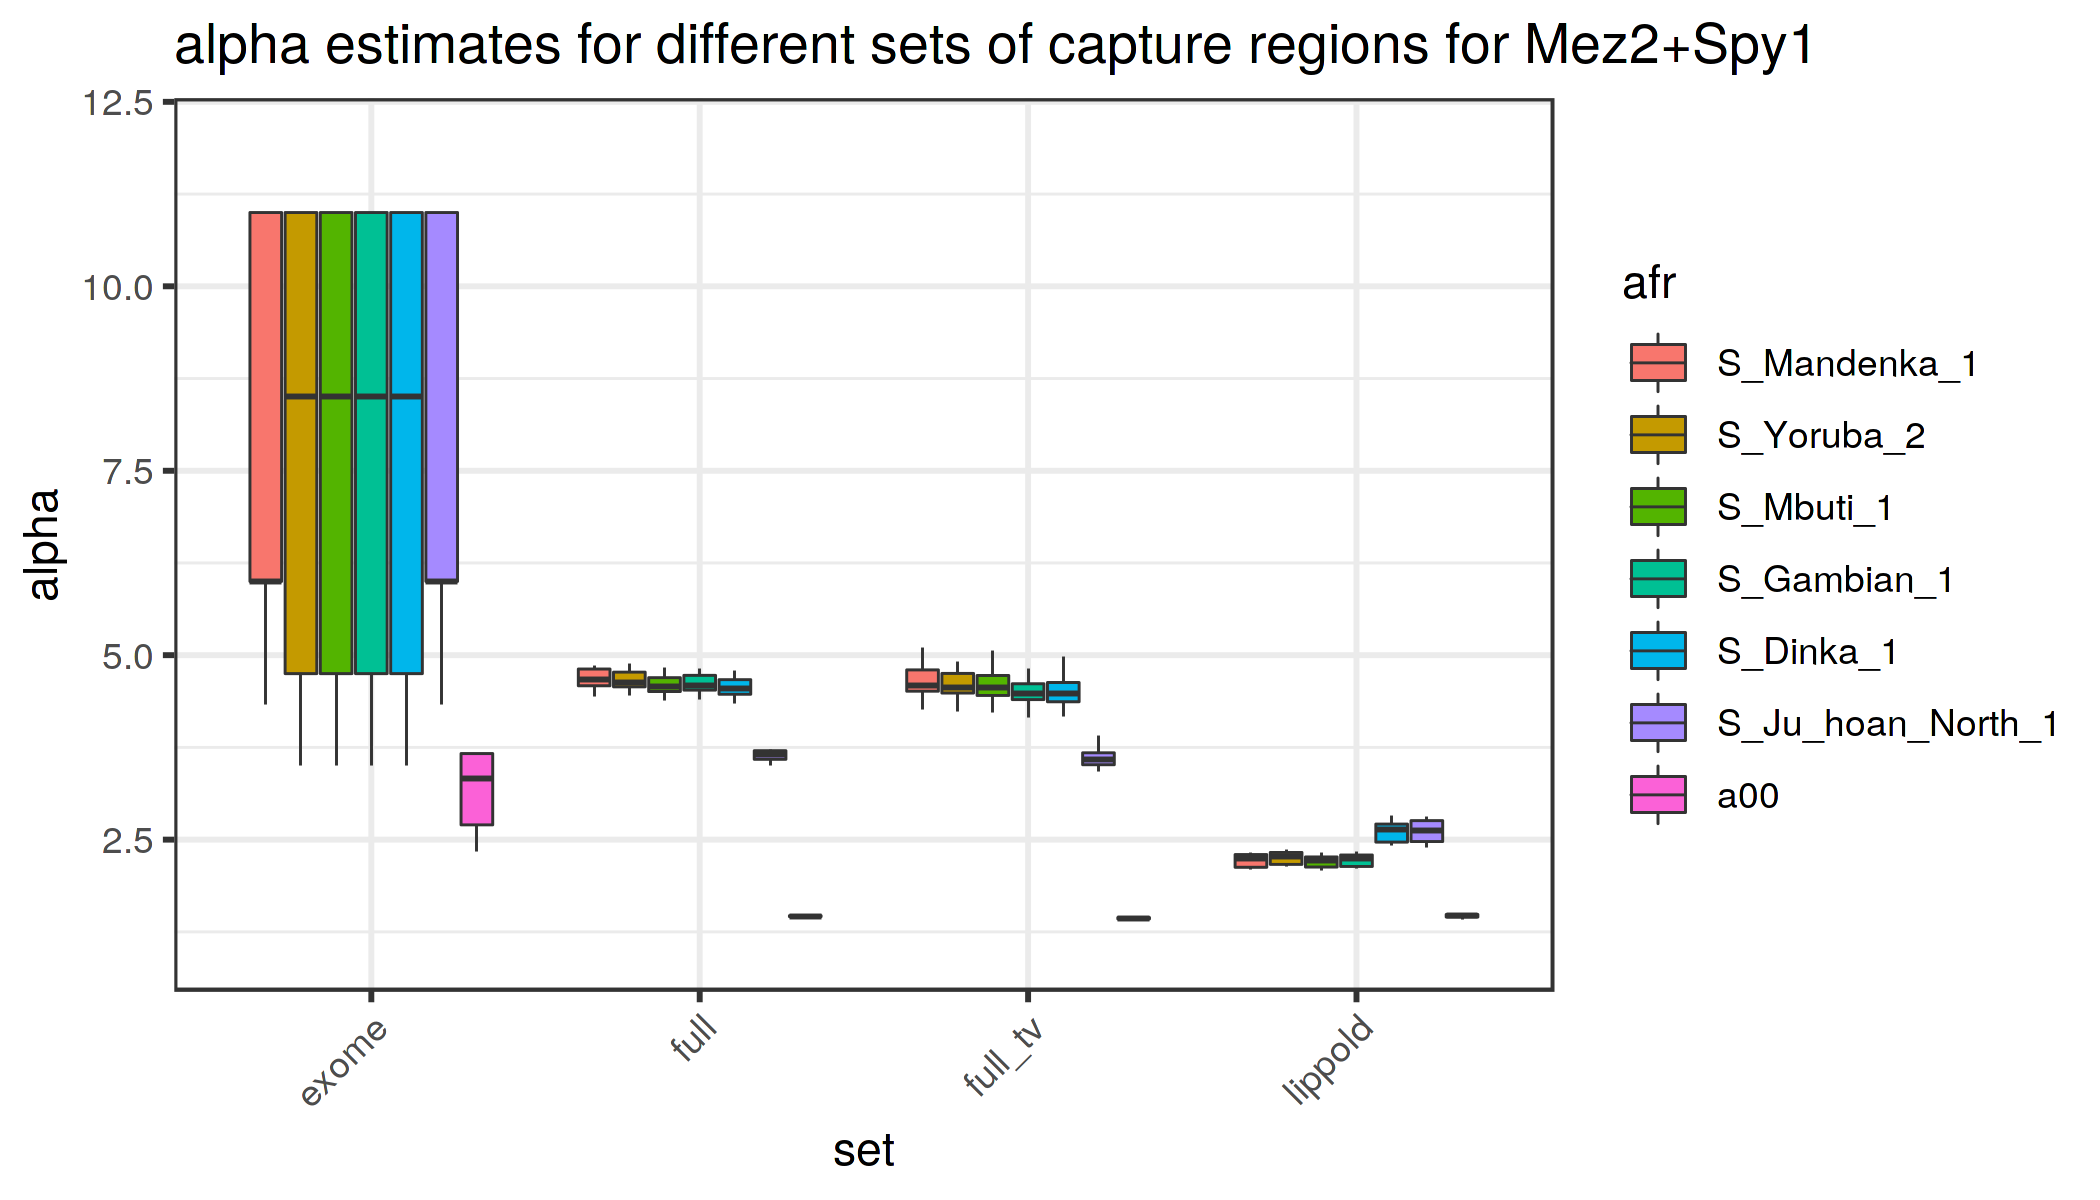

In [32]:
set_dim(7, 4)

tarch %>% filter(arch == "neand", !str_detect(set, "^x")) %>% 
ggplot(aes(set, alpha, fill = fct_reorder(afr, alpha, .desc = TRUE))) +
    geom_boxplot(outlier.shape = NA, size = 0.25) +
    guides(fill = guide_legend("afr")) +
    coord_cartesian(y = c(1, 12)) +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    ggtitle("alpha estimates for different sets of capture regions for Mez2+Spy1")

Warning message:
“Removed 14 rows containing non-finite values (stat_boxplot).”

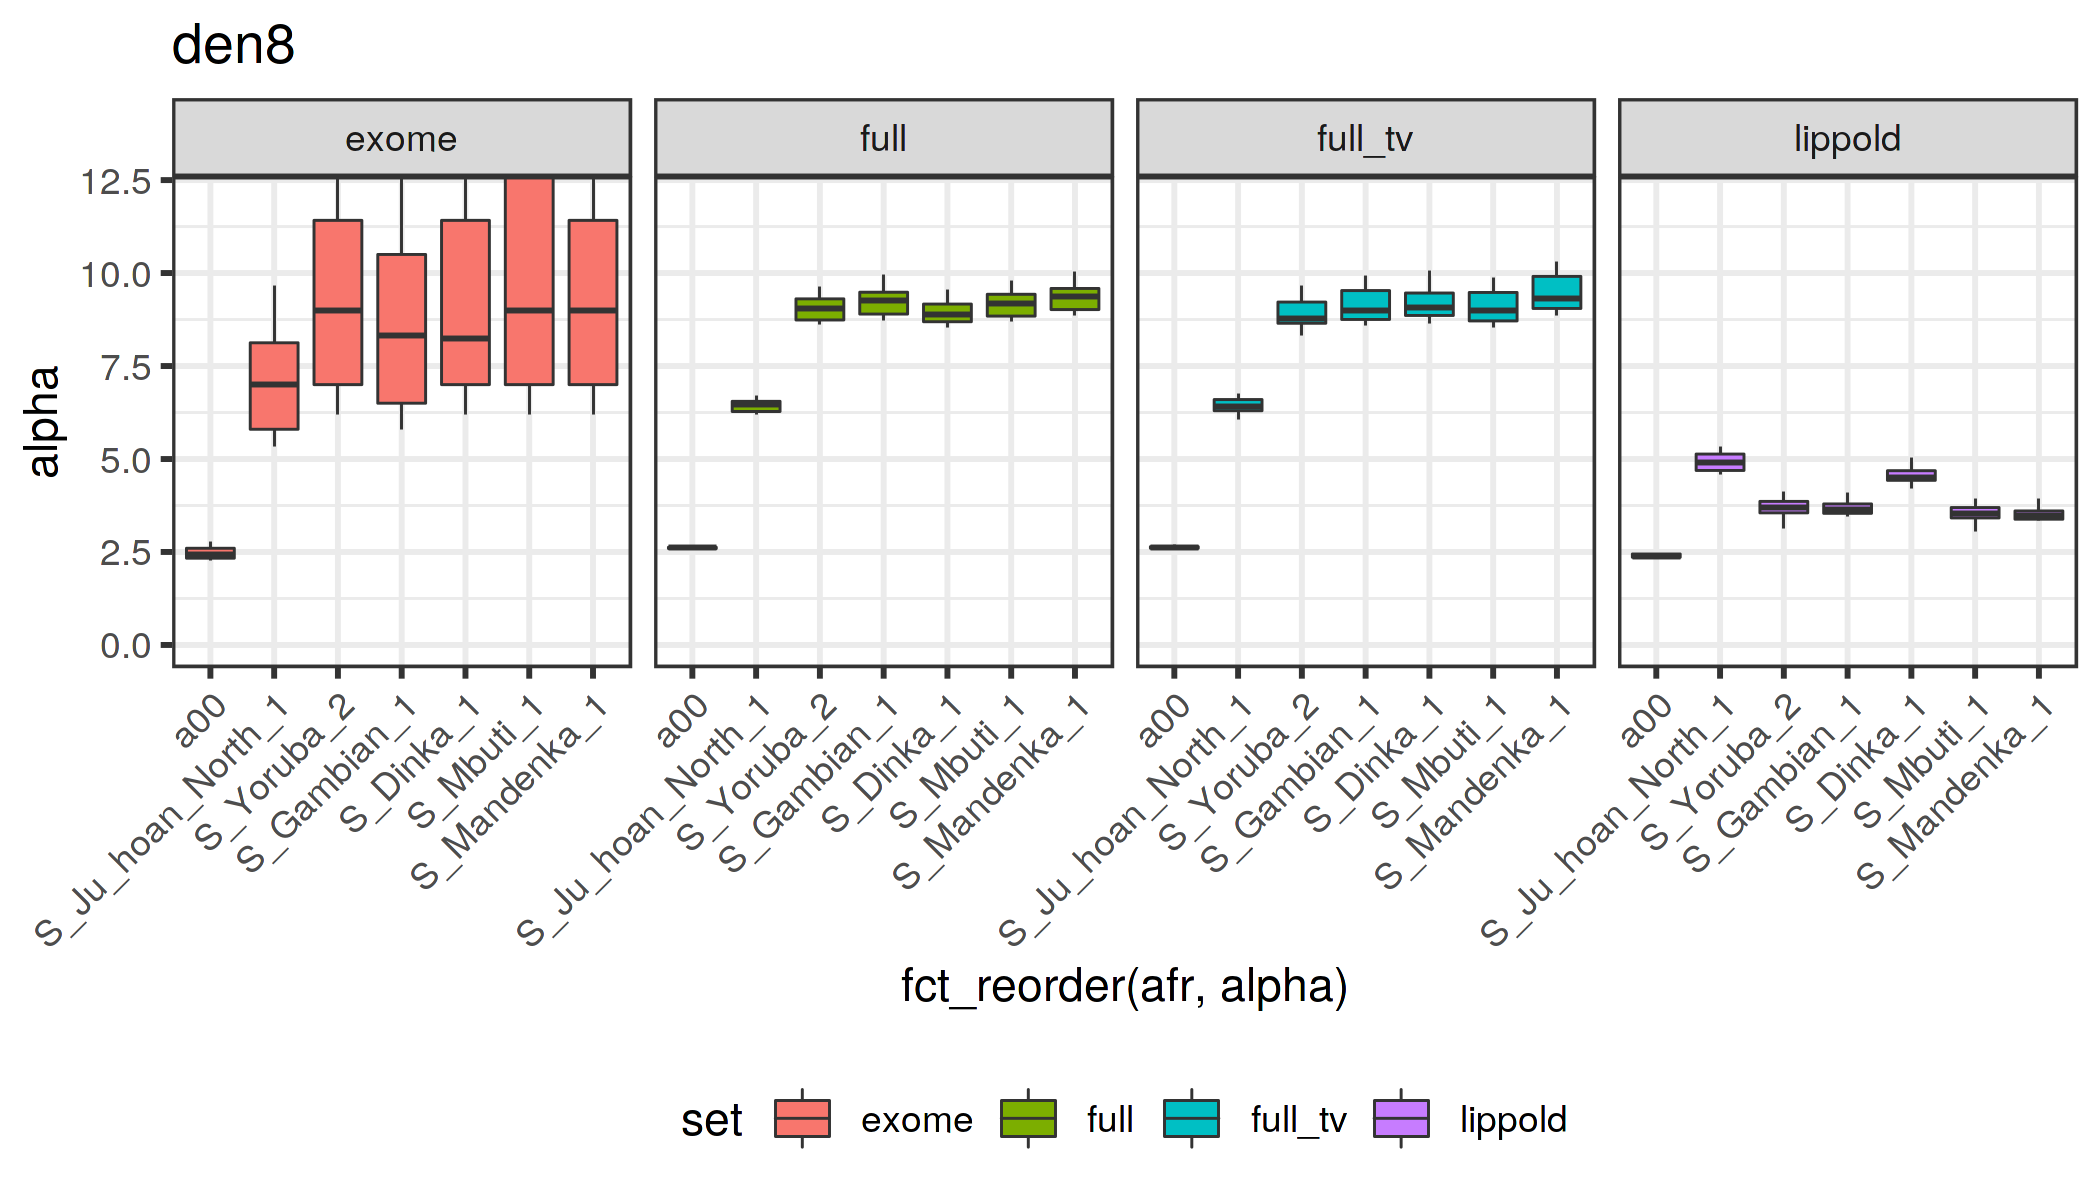

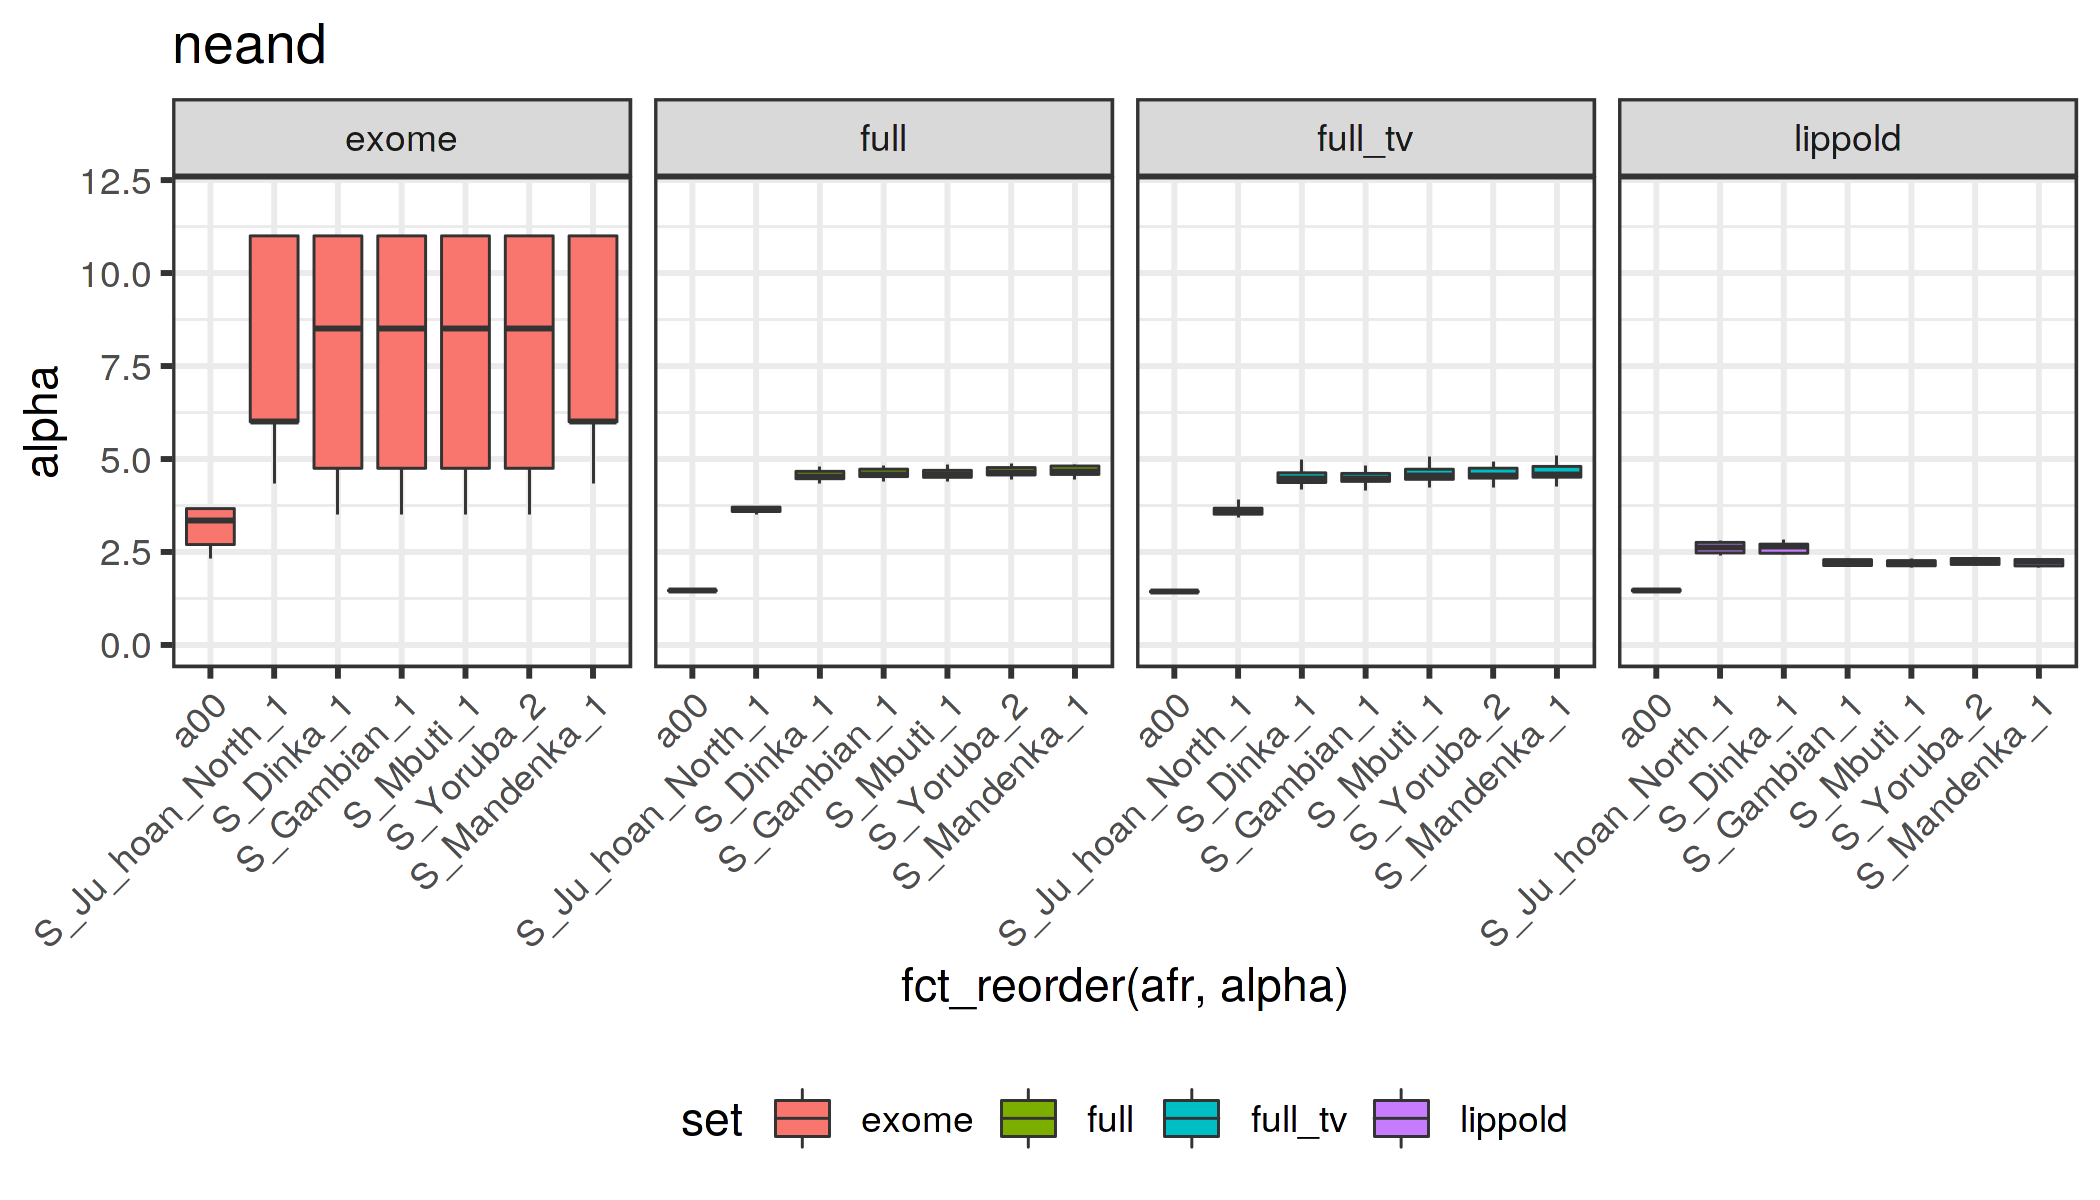

In [12]:
set_dim(7, 4)

tmrca %>% filter(arch == "den8") %>% 
unnest(counts_arch) %>%
ggplot(aes(fct_reorder(afr, alpha), alpha, fill = set)) +
    geom_boxplot(outlier.shape = NA, size = 0.25) +
    facet_wrap(~ set, ncol = 4) +
    guides(fill = guide_legend("set")) +
    coord_cartesian(y = c(0, 12)) +
    theme_bw() +
    ggtitle("den8") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

tmrca %>% filter(arch == "neand") %>% 
unnest(counts_arch) %>%
ggplot(aes(fct_reorder(afr, alpha), alpha, fill = set)) +
    geom_boxplot(outlier.shape = NA, size = 0.25) +
    facet_wrap(~ set, ncol = 4) +
    guides(fill = guide_legend("set")) +
    coord_cartesian(y = c(0, 12)) +
    theme_bw() +
    ggtitle("neand") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

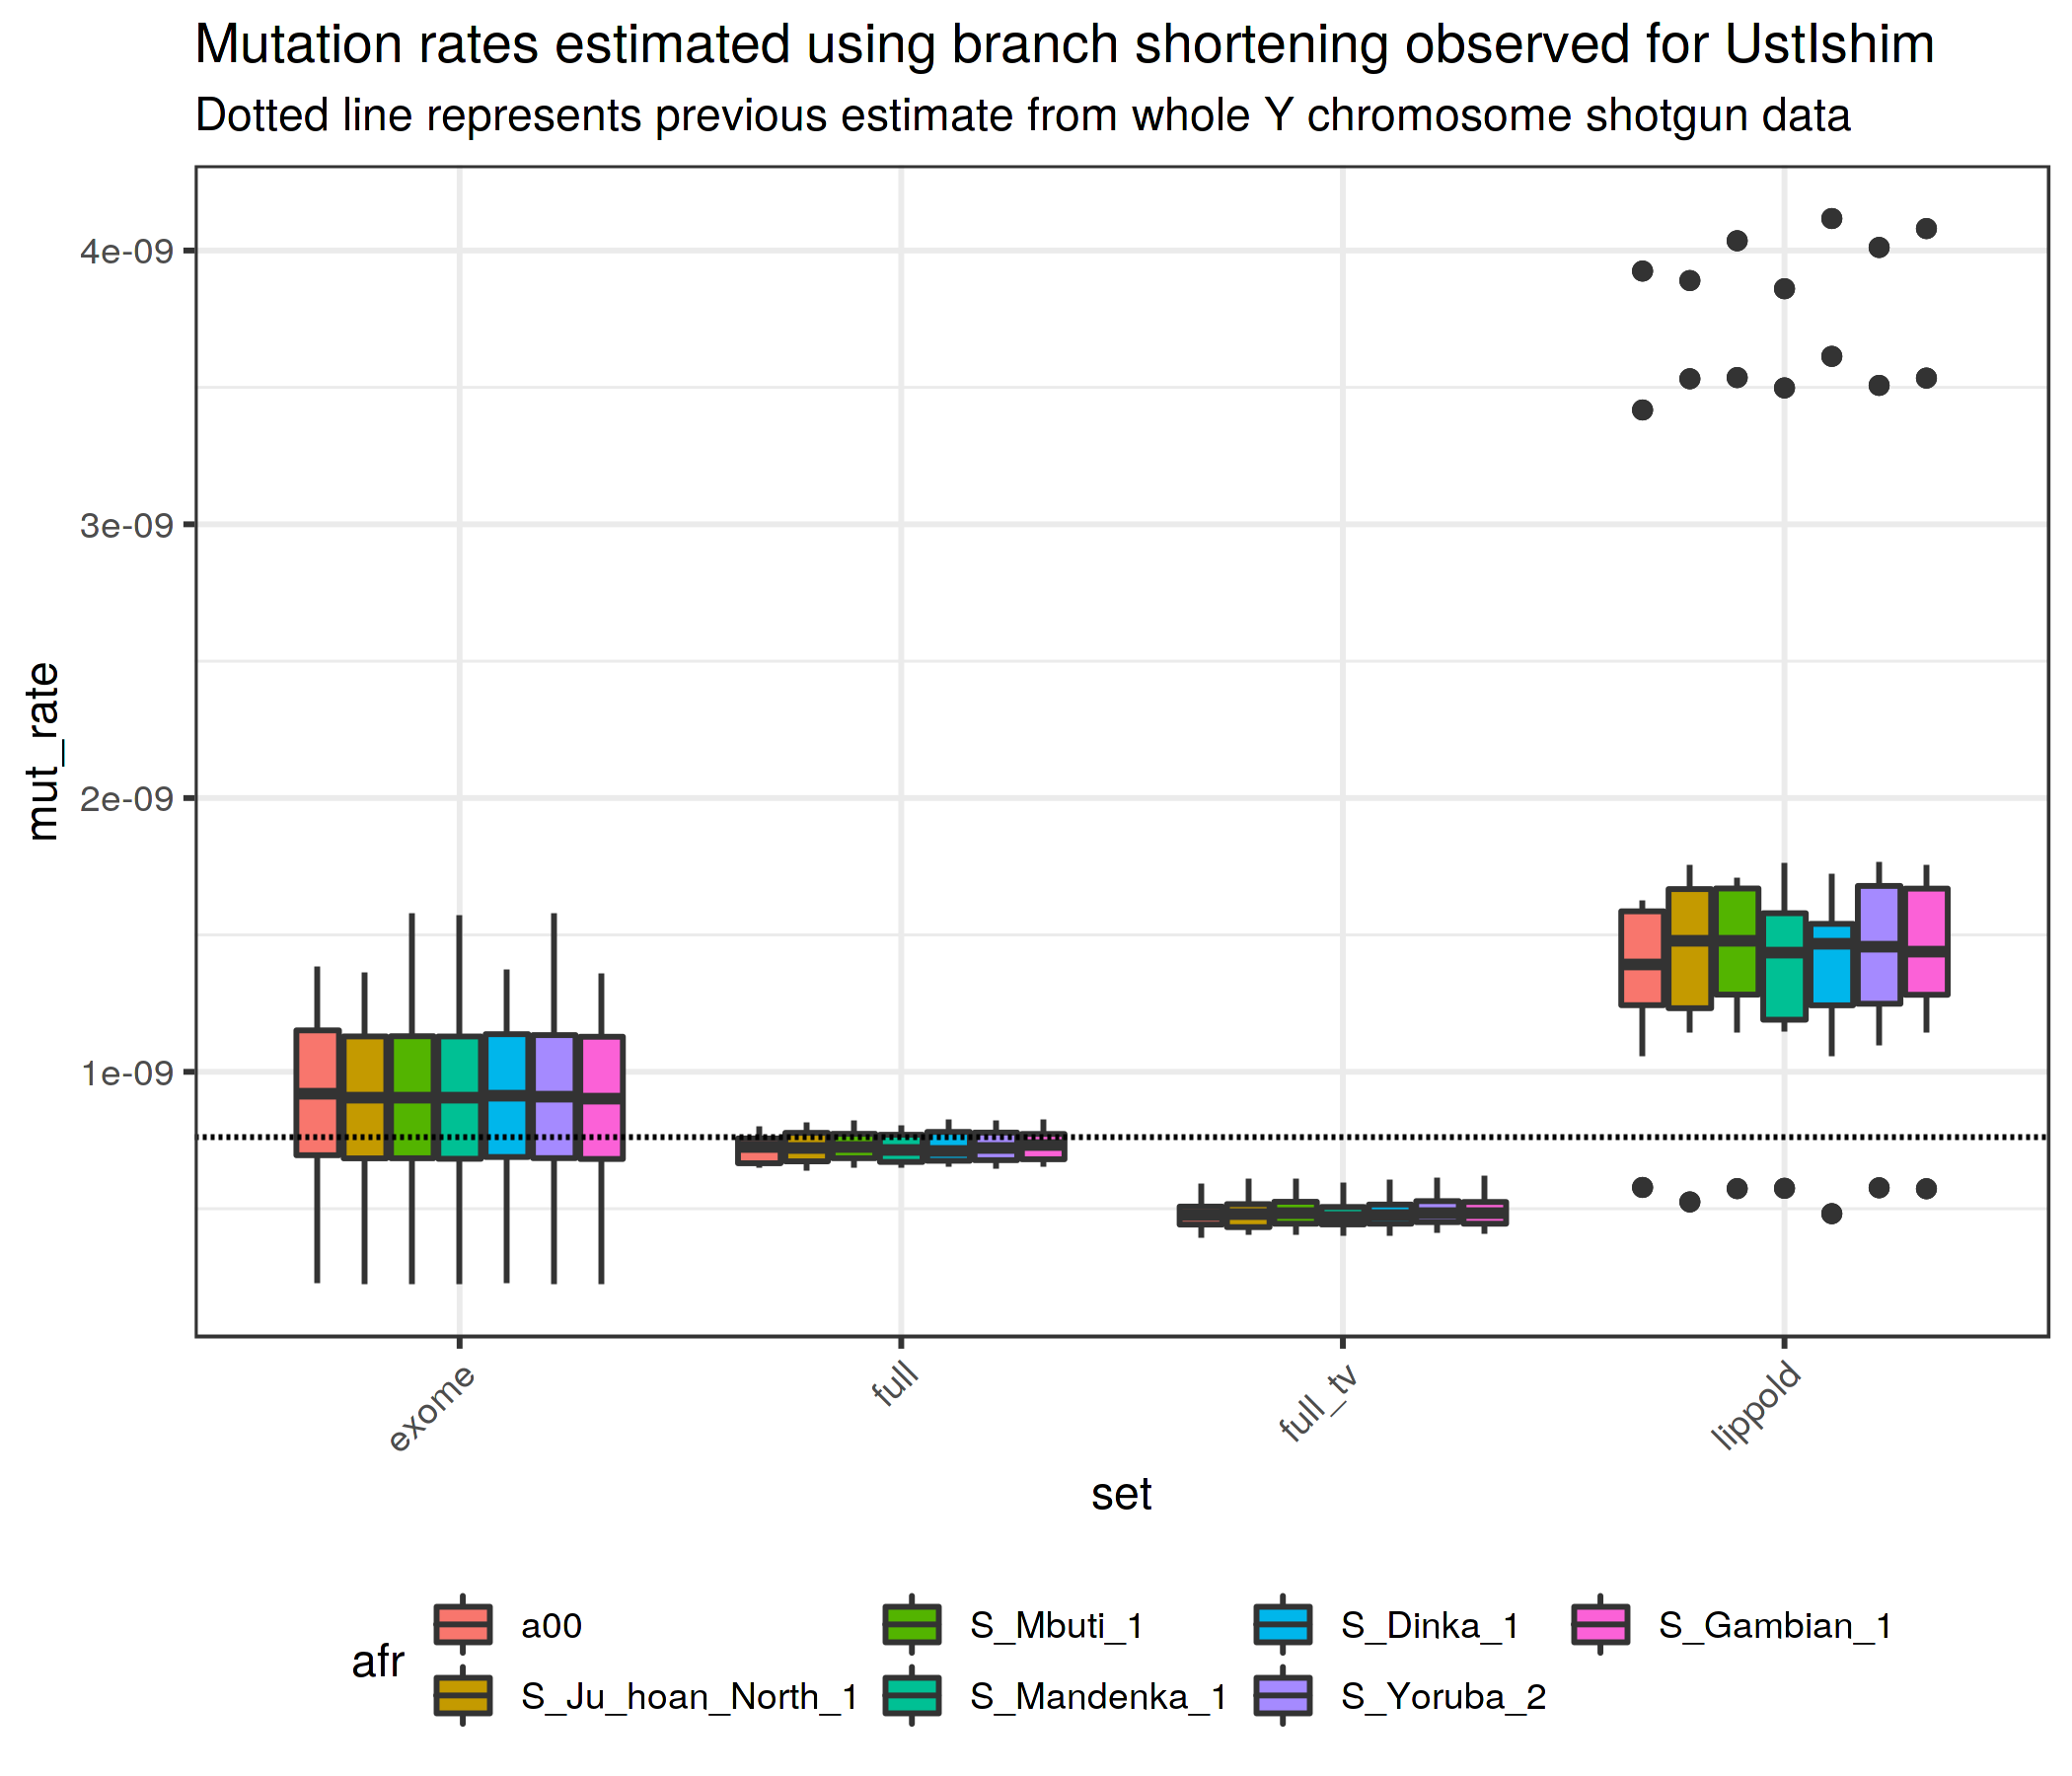

In [13]:
set_dim(7, 6)

tmrca %>%
ggplot(aes(set, mut_rate, fill = fct_reorder(afr, tmrca_afr, .desc = TRUE))) +
    geom_boxplot() +
    geom_hline(yintercept = 7.6e-10, linetype = 2, size = 0.5) +
    guides(fill = guide_legend("afr")) +
    theme_bw() +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45)) +
    ggtitle("Mutation rates estimated using branch shortening observed for UstIshim",
            "Dotted line represents previous estimate from whole Y chromosome shotgun data")

In [74]:
a = 8
d = 7
e = 5

In [100]:
a = 870
d = 457
e = 612

In [91]:
a = 164
d = 306
e = 396

In [101]:
a / (a + d + e)

[1] 0.4486849

In [102]:
p_ci <- binom.test(x = a, n = a + d + e, conf.level = 0.95)$conf.int
p_ci[1]
p_ci[2]

[1] 0.4263813

[1] 0.4711439

In [103]:
(alpha_ci <- (1 + p_ci)/(1 - p_ci))

[1] 2.486637 2.781747
attr(,"conf.level")
[1] 0.95

In [104]:
alpha_ci * 254000

[1] 631605.7 706563.8
attr(,"conf.level")
[1] 0.95

In [98]:
alpha_ci * 254000

[1] 353507.5 394860.8
attr(,"conf.level")
[1] 0.95

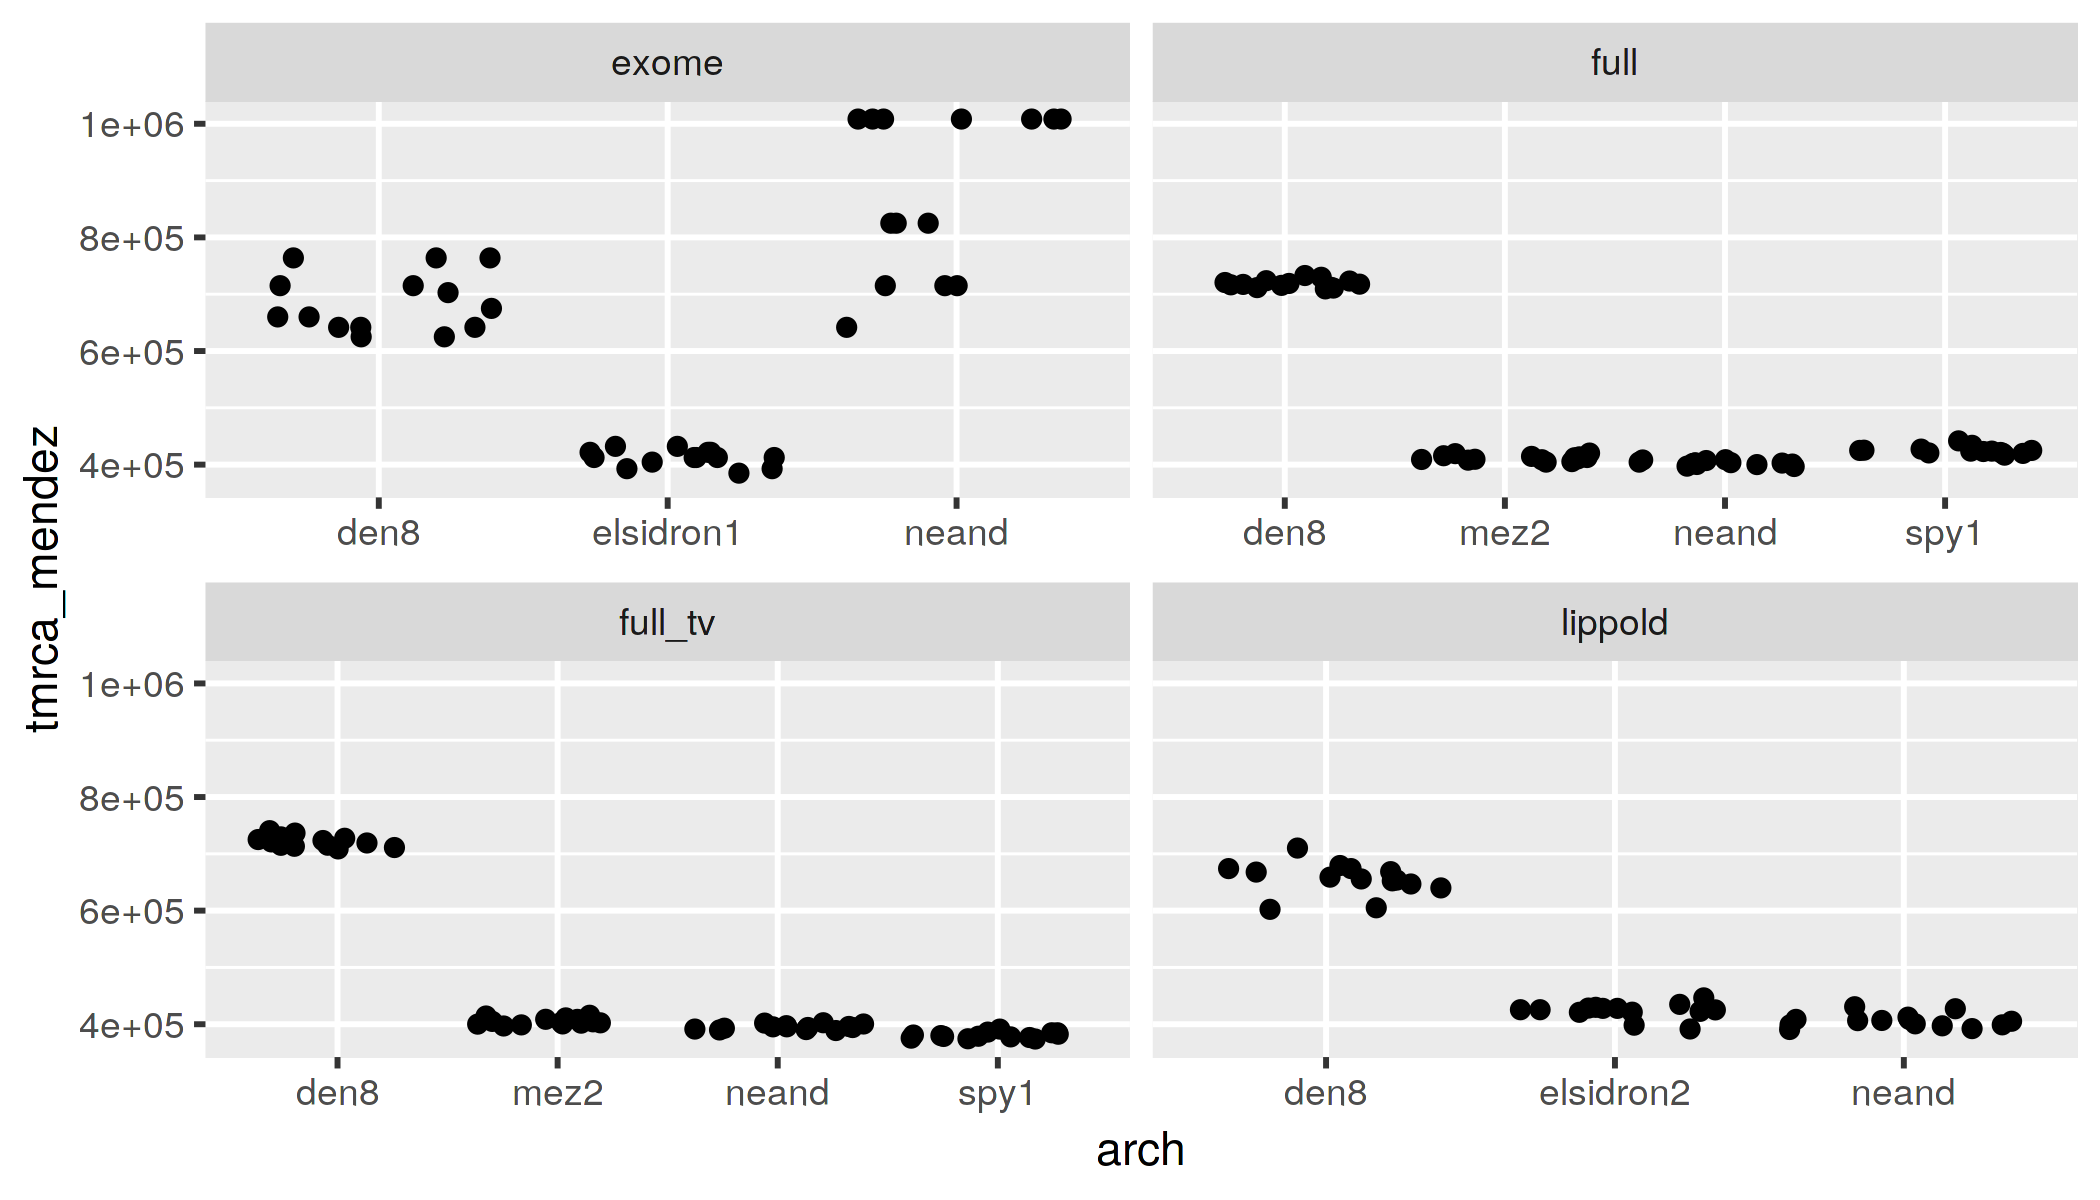

In [53]:
tarch %>%
    filter(afr == "a00") %>%
    unnest(counts_arch) %>%
    ggplot(aes(arch, tmrca_mendez)) + geom_jitter() + facet_wrap(~ set, scales = "free_x")

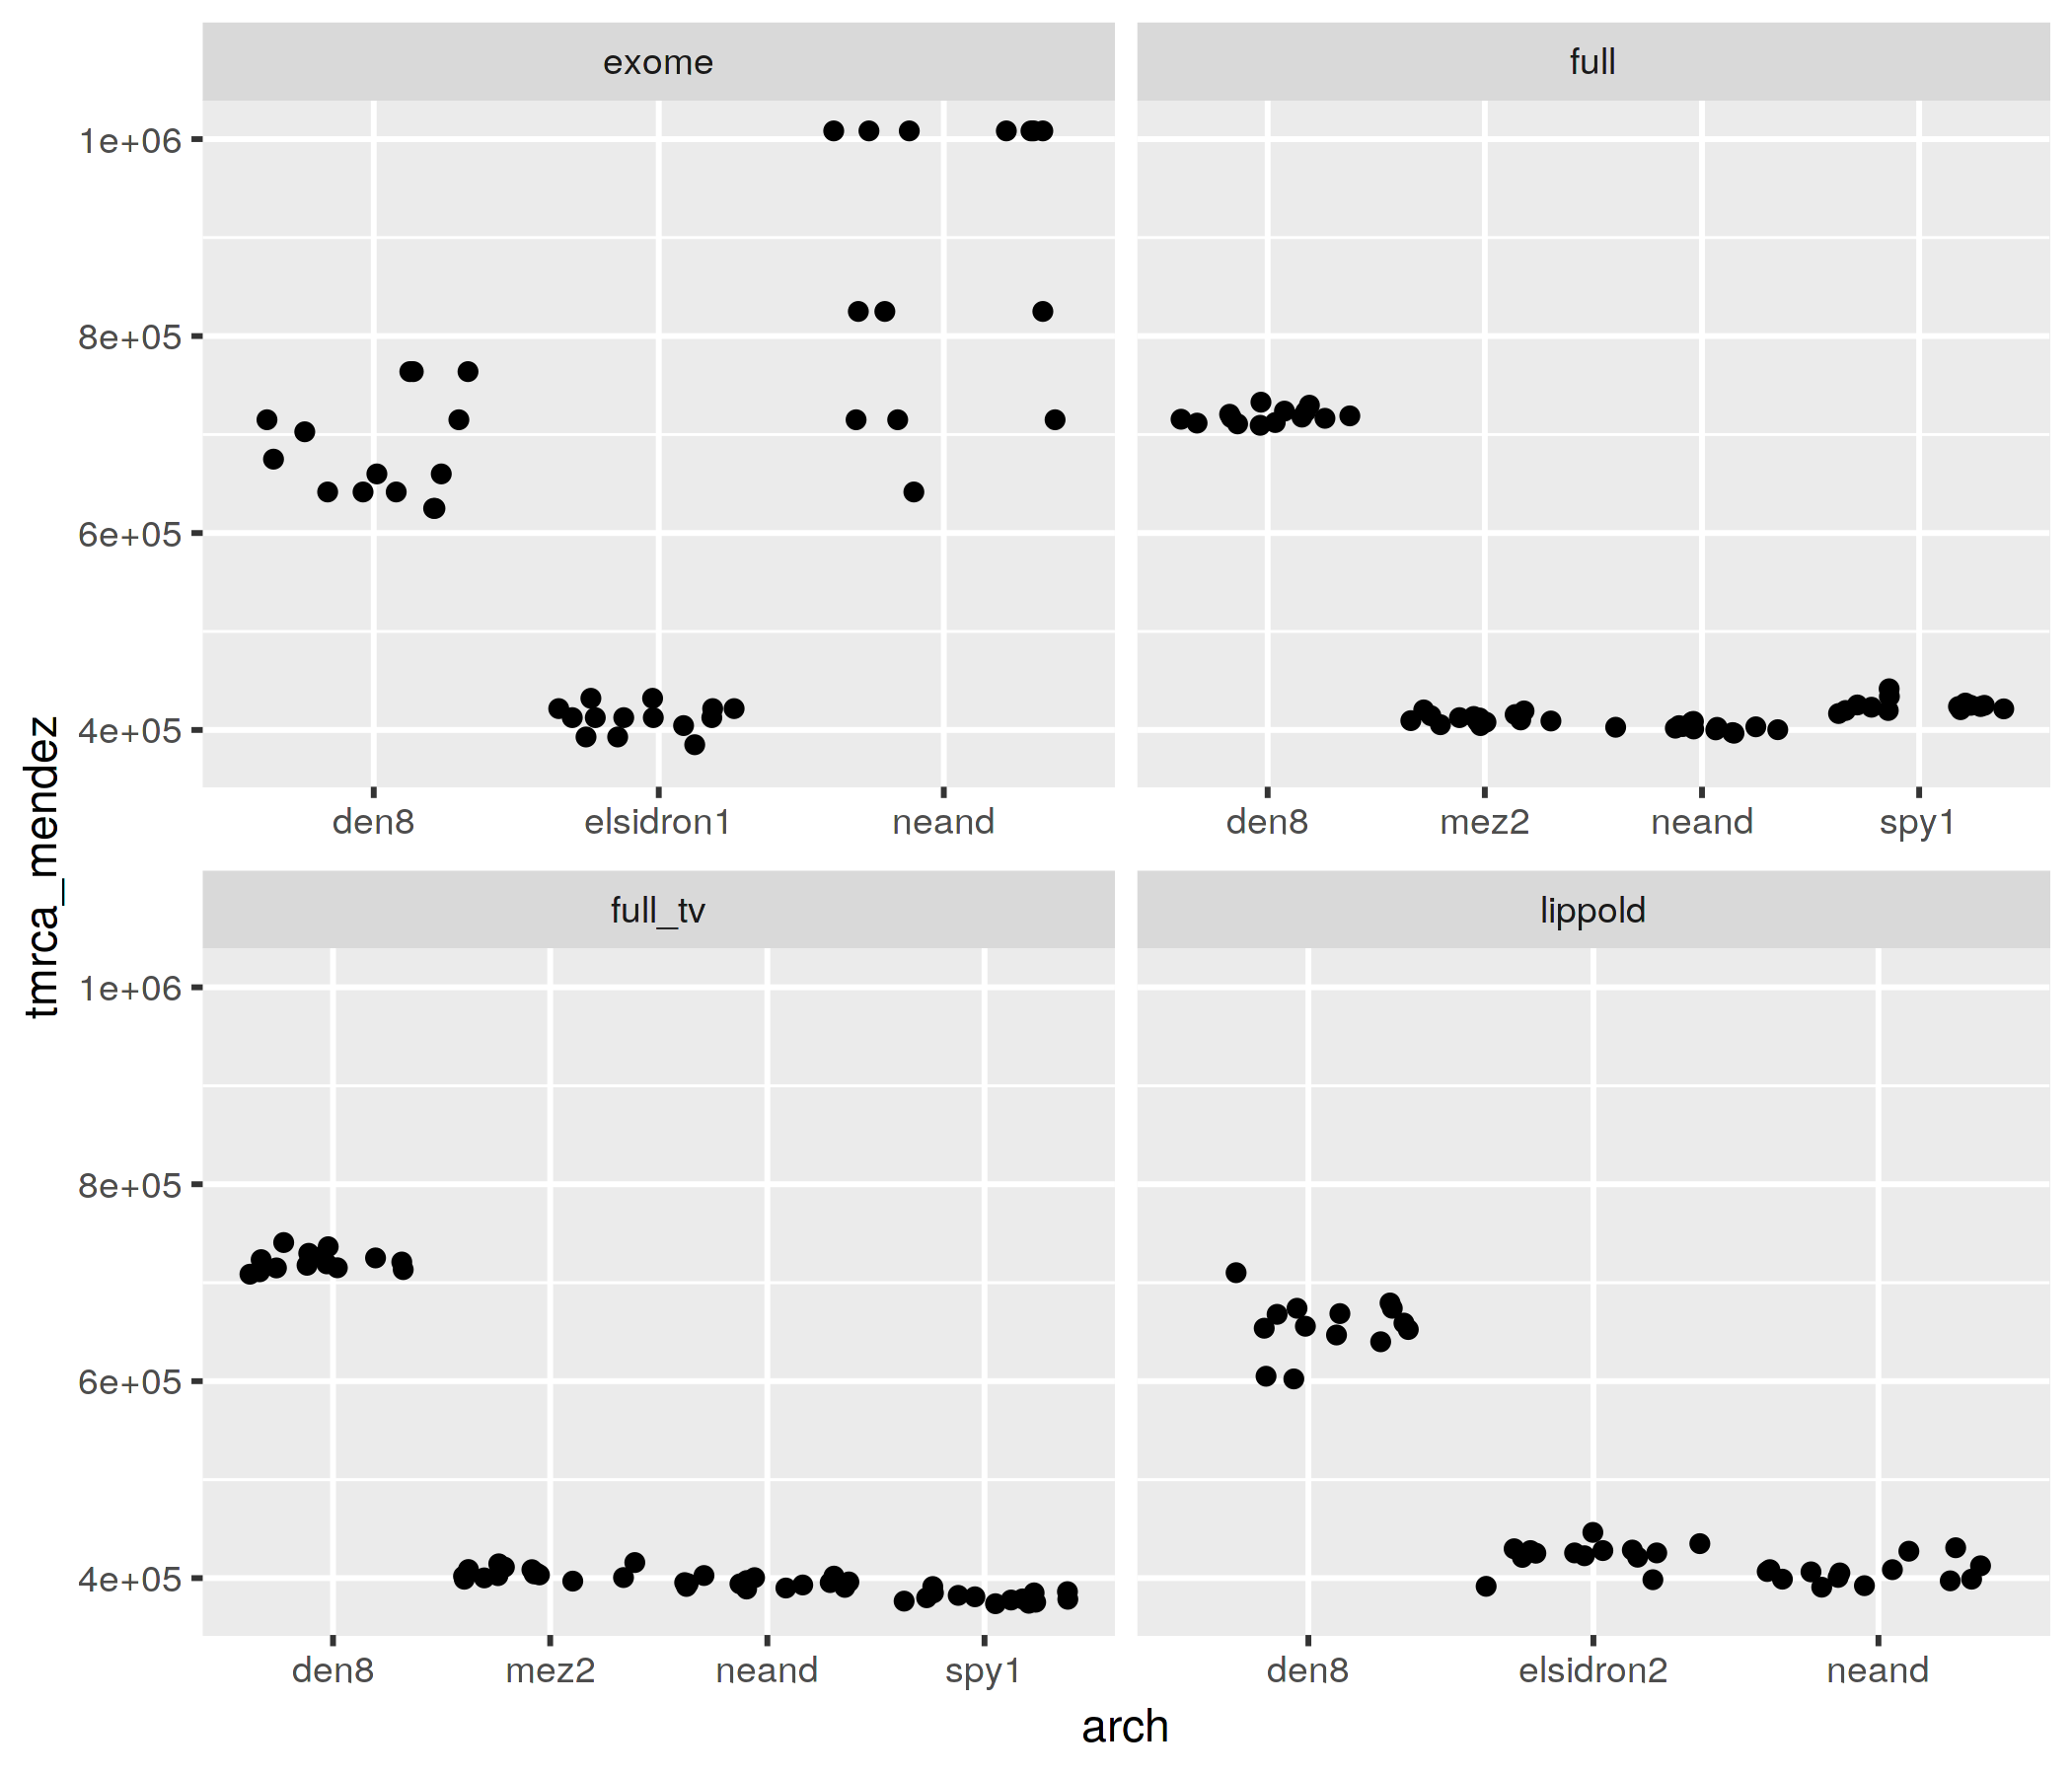

In [14]:
tmrca %>%
    filter(afr == "a00") %>%
    unnest(counts_arch) %>%
    ggplot(aes(arch, tmrca_mendez)) + geom_jitter() + facet_wrap(~ set, scales = "free_x")

In [55]:
tarch %>%
    filter(set == "exome", afr == "a00") %>%
    unnest(counts_arch) %>%
    group_by(arch, afr) %>%
    summarise_if(is.numeric, mean)

arch,afr,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,tmrca_mendez,a,b,c,d,e,f,total
den8,a00,575947.2,2.492063,228214.3,237642.9,218785.7,9.357731e-10,685317.5,7.500000,1,0,5.285714,4.857143,9.285714,32952.64
elsidron1,a00,341020.4,1.497899,228214.3,237642.9,218785.7,9.357731e-10,411922.3,3.785714,0,0,8.357143,6.857143,10.714286,48727.93
neand,a00,753321.4,3.200000,228214.3,237642.9,218785.7,9.357731e-10,880000.0,4.000000,0,0,1.857143,2.000000,11.000000,20395.14


In [16]:
tmrca %>%
    filter(set == "exome", afr == "a00") %>%
    unnest(counts_arch) %>%
    group_by(arch, afr) %>%
    summarise_if(is.numeric, mean)

arch,afr,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,tmrca_mendez,a,b,c,d,e,f,total
den8,a00,575947.2,2.492063,228214.3,237642.9,218785.7,9.357731e-10,685317.5,7.500000,1,0,5.285714,4.857143,9.285714,32952.64
elsidron1,a00,341020.4,1.497899,228214.3,237642.9,218785.7,9.357731e-10,411922.3,3.785714,0,0,8.357143,6.857143,10.714286,48727.93
neand,a00,753321.4,3.200000,228214.3,237642.9,218785.7,9.357731e-10,880000.0,4.000000,0,0,1.857143,2.000000,11.000000,20395.14


In [17]:
tmrca %>%
    filter(set == "lippold", afr == "a00") %>%
    unnest(counts_arch) %>%
    group_by(arch, afr) %>%
    summarise_if(is.numeric, mean)

arch,afr,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,tmrca_mendez,a,b,c,d,e,f,total
den8,a00,387095.2,2.386814,160020.1,189863.9,130176.2,1.628451e-09,656373.9,73.07143,1.92857143,2.428571,58.92857,47.00000,82.78571,295207.9
elsidron2,a00,248851.7,1.539517,160020.1,189863.9,130176.2,1.628451e-09,423367.1,47.21429,1.92857143,5.285714,106.21429,70.50000,88.92857,409403.7
neand,a00,237332.7,1.476630,160020.1,189863.9,130176.2,1.628451e-09,406073.4,16.71429,0.07142857,1.857143,36.21429,34.21429,58.14286,190576.6


In [19]:
tmrca %>%
    filter(set == "full", afr == "a00") %>%
    unnest(counts_arch) %>%
    group_by(arch, afr) %>%
    summarise_if(is.numeric, mean)

arch,afr,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,tmrca_mendez,a,b,c,d,e,f,total
den8,a00,689054.0,2.612988,263713.1,285163.6,242262.6,7.199248e-10,718571.8,834.00000,32.28571,13.571429,457.07143,577.2143,1083.0000,3293926.1
mez2,a00,394607.1,1.496869,263713.1,285163.6,242262.6,7.199248e-10,411638.9,87.57143,13.85714,8.857143,170.71429,182.0000,521.2143,1155292.5
neand,a00,386007.1,1.464270,263713.1,285163.6,242262.6,7.199248e-10,402674.3,157.21429,19.28571,10.214286,310.92857,366.5714,736.8571,2210584.1
spy1,a00,407286.7,1.544736,263713.1,285163.6,242262.6,7.199248e-10,424802.5,35.35714,7.50000,0.500000,57.42857,72.5000,632.7143,530750.1


In [20]:
tmrca %>%
    filter(set == "full_tv", afr == "a00") %>%
    unnest(counts_arch) %>%
    group_by(arch, afr) %>%
    summarise_if(is.numeric, mean)

arch,afr,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,tmrca_mendez,a,b,c,d,e,f,total
den8,a00,737291.2,2.624425,281002.5,311236.3,250768.7,4.812289e-10,721716.9,564.50000,8.785714,8.6428571,301.85714,393.35714,558.14286,3264232.0
mez2,a00,413751.3,1.473341,281002.5,311236.3,250768.7,4.812289e-10,405168.7,51.28571,2.071429,6.6428571,109.42857,107.50000,115.42857,1143478.6
neand,a00,403483.0,1.436924,281002.5,311236.3,250768.7,4.812289e-10,395154.2,96.64286,6.500000,7.2142857,205.21429,237.42857,220.42857,2190185.2
spy1,a00,388640.2,1.383652,281002.5,311236.3,250768.7,4.812289e-10,380504.3,17.14286,4.428571,0.2142857,39.78571,49.71429,90.78571,525485.4


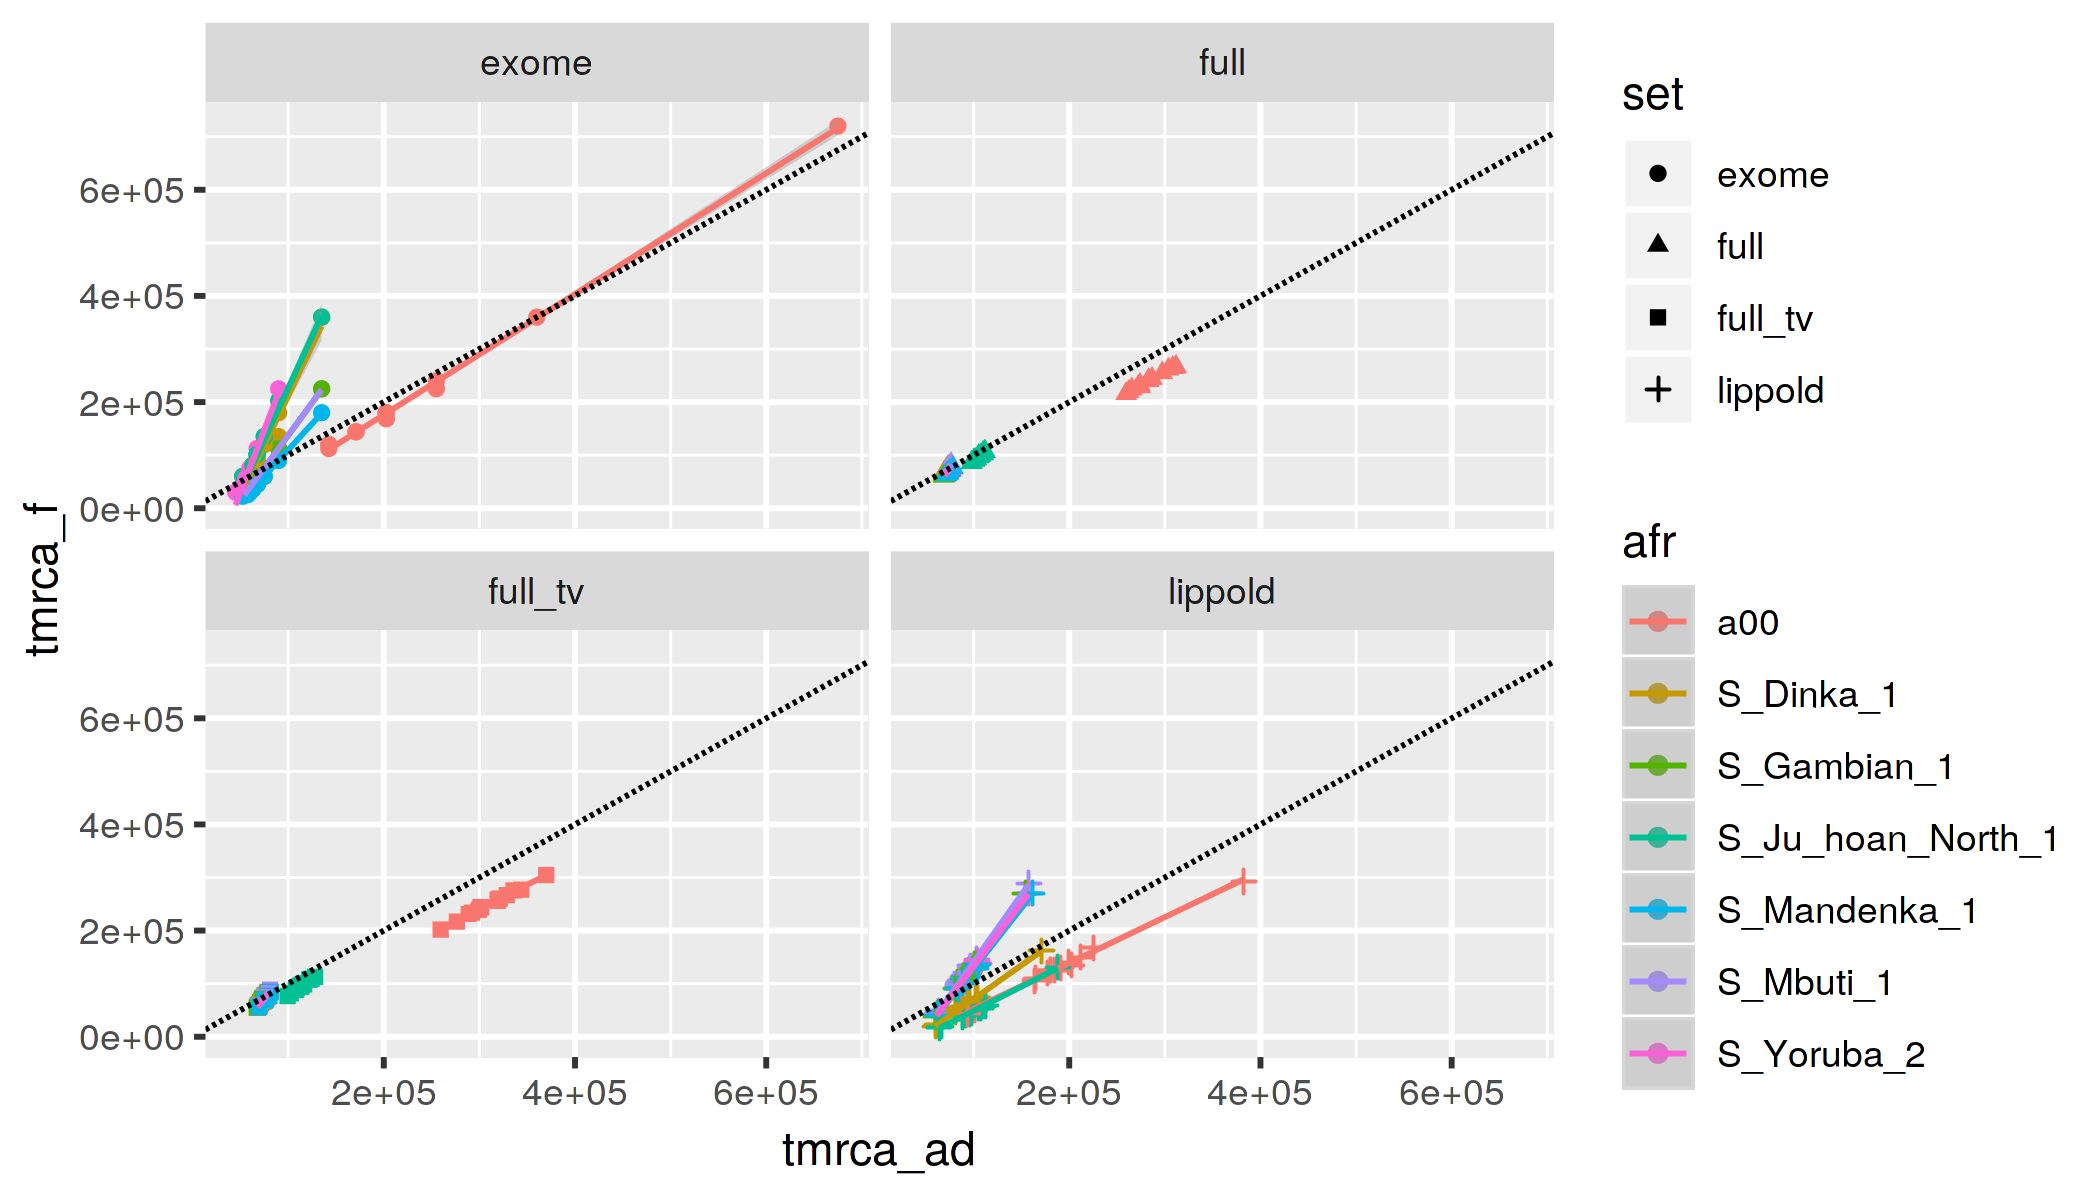

In [25]:
set_dim(7, 4)

filter(tarch, arch == "den8", !str_detect(set, "^x")) %>%
ggplot(aes(tmrca_ad, tmrca_f, color = afr, shape = set)) +
    geom_point() +
    geom_smooth(method = "lm", size = 0.5) +
    geom_abline(slope = 1, linetype = 2) +
    facet_wrap(~ set)